# Projeto de Modelagem: Previsão de Preços de Casas

## 📋 Introdução e Objetivos

Este projeto tem como objetivo colocar em prática habilidades de análise de dados e modelagem preditiva através de:

1. **Análise Exploratória de Dados (EDA)**: Limpeza, tratamento de ausências e investigação das relações entre variáveis
2. **Modelagem de Regressão**: Implementação de regressão linear simples, múltipla e polinomial
3. **Modelagem de Classificação**: Implementação de Naive Bayes e Regressão Logística
4. **Avaliação de Desempenho**: Métricas apropriadas para cada tipo de problema
5. **Otimização**: Validação cruzada e tuning de hiperparâmetros

### Dataset: House Prices - Advanced Regression Techniques

**Fonte**: [Kaggle - House Prices: Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

**Licença**: O dataset é disponibilizado pela Kaggle para fins educacionais e de competição. É um dataset público sem restrições de uso comercial específicas para fins educacionais.

**Descrição**: 
- **Variável-alvo (Regressão)**: `SalePrice` - Preço de venda da casa em dólares
- **Variável-alvo (Classificação)**: Criada a partir de `SalePrice` (acima/média = 1, abaixo = 0)
- **Tamanho**: 1460 observações com 80 features
- **Tipo**: Dados imobiliários de Ames, Iowa (EUA)

**Hipóteses de Negócio**:
1. O preço de uma casa está relacionado com sua área total, qualidade geral e localização
2. Características como número de quartos, banheiros e garagem influenciam significativamente o preço
3. Casas mais novas e com melhor qualidade de construção têm preços mais altos
4. A localização (bairro) é um fator determinante no preço final

**Ferramentas Utilizadas**: pandas, seaborn, statsmodels, sklearn, pycaret


In [ ]:
# Imports e Configuração
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from scipy.stats import shapiro

from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     RandomizedSearchCV, KFold, cross_validate,
                                     StratifiedKFold)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)

try:
    from pycaret.regression import setup as setup_reg, compare_models, tune_model
    from pycaret.classification import setup as setup_clf
    PYCARET_AVAILABLE = True
except ImportError:
    PYCARET_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

✓ Imports realizados com sucesso


In [ ]:
## 1️⃣ CARREGAMENTO E INSPEÇÃO INICIAL DOS DADOS

df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
print(f"Dimensões: {df.shape}")
print(f"\nTipos de dados:\n{df.dtypes.value_counts()}")
print(f"\nPrimeiras linhas:")
df.head()

Dimensões originais: (1460, 81)

Primeiras linhas:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleTyp

Análise de Valores Ausentes:

       Coluna  Valores Faltantes  Percentual (%)
       PoolQC               1453           99.52
  MiscFeature               1406           96.30
        Alley               1369           93.77
        Fence               1179           80.75
   MasVnrType                872           59.73
  FireplaceQu                690           47.26
  LotFrontage                259           17.74
   GarageQual                 81            5.55
 GarageFinish                 81            5.55
   GarageType                 81            5.55
  GarageYrBlt                 81            5.55
   GarageCond                 81            5.55
 BsmtFinType2                 38            2.60
 BsmtExposure                 38            2.60
     BsmtCond                 37            2.53
     BsmtQual                 37            2.53
 BsmtFinType1                 37            2.53
   MasVnrArea                  8            0.55
   Electrical                  1       

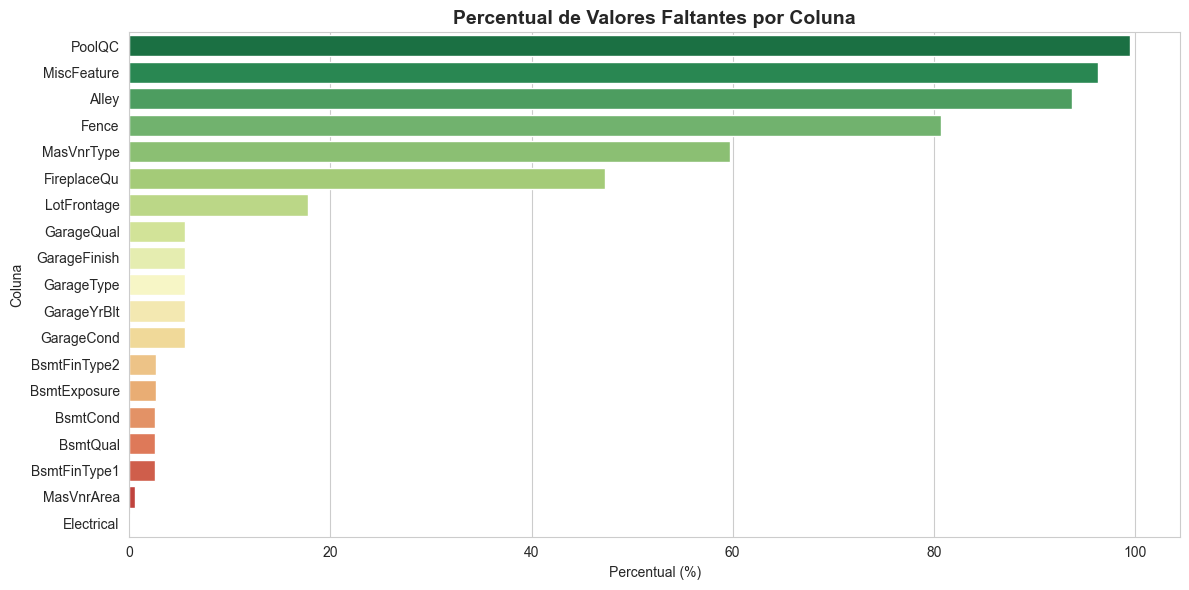

In [10]:
## 2️⃣ ANÁLISE DE VALORES AUSENTES

# Análise de nulos
missing_analysis = pd.DataFrame({
    'Coluna': df.columns,
    'Valores Faltantes': df.isnull().sum(),
    'Percentual (%)': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Percentual (%)', ascending=False)

print("Análise de Valores Ausentes:\n")
print(missing_analysis.to_string(index=False))

# Visualizar
plt.figure(figsize=(12, 6))
missing_analysis_filtered = missing_analysis[missing_analysis['Percentual (%)'] > 0]
sns.barplot(data=missing_analysis_filtered, x='Percentual (%)', y='Coluna', palette='RdYlGn_r')
plt.title('Percentual de Valores Faltantes por Coluna', fontsize=14, fontweight='bold')
plt.xlabel('Percentual (%)')
plt.tight_layout()
plt.show()

In [ ]:
## 3️⃣ LIMPEZA E TRATAMENTO DE DADOS

# Passo 1: Remover coluna Id (identificador único, não útil para modelagem)
df = df.drop(columns=['Id'])

# Passo 2: Remover duplicatas
duplicates_before = len(df)
df = df.drop_duplicates()
print(f"Linhas removidas por duplicação: {duplicates_before - len(df)}")

# Passo 3: Remover colunas com >50% de nulos
cols_to_drop = missing_analysis[missing_analysis['Percentual (%)'] > 50]['Coluna'].tolist()
# Garantir que Id não está na lista (já foi removido)
cols_to_drop = [col for col in cols_to_drop if col != 'Id']
print(f"\nColunas removidas (>50% nulos): {cols_to_drop}")
df = df.drop(columns=cols_to_drop)

# Passo 4: Tratamento contextual de nulos
# Para variáveis numéricas: mediana
# Para variáveis categóricas: moda ou 'None' quando faz sentido
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remover SalePrice das numéricas para não preencher
if 'SalePrice' in numeric_cols:
    numeric_cols.remove('SalePrice')

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        # Para algumas colunas, 'None' ou 'NA' pode ser mais apropriado
        mode_value = df[col].mode()
        if len(mode_value) > 0:
            df[col] = df[col].fillna(mode_value[0])
        else:
            df[col] = df[col].fillna('None')

# Passo 5: Detectar outliers na variável-alvo (SalePrice) usando IQR
# Não removemos outliers de features, apenas identificamos
rows_before = len(df)
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]
print(f"\nOutliers detectados em SalePrice: {len(outliers)}")
print(f"Limites: [{lower_bound:.2f}, {upper_bound:.2f}]")
# Opcional: remover outliers extremos (comentado para manter mais dados)
# df = df[(df['SalePrice'] >= lower_bound) & (df['SalePrice'] <= upper_bound)]

print(f"\nDimensões após limpeza: {df.shape}")
print(f"Valores faltantes restantes: {df.isnull().sum().sum()}")

KeyError: 'Date'

In [ ]:
## 4️⃣ ANÁLISE EXPLORATÓRIA (EDA)

# Estatísticas descritivas
print("Estatísticas Descritivas:\n")
print(df.describe().T)

# Distribuição da variável-alvo (SalePrice)
print("\n\nDistribuição de SalePrice:")
print(df['SalePrice'].describe())

# Visualização da variável-alvo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma
axes[0, 0].hist(df['SalePrice'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição de SalePrice', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Preço de Venda ($)')
axes[0, 0].set_ylabel('Frequência')

# Boxplot
axes[0, 1].boxplot(df['SalePrice'], vert=True)
axes[0, 1].set_title('Boxplot de SalePrice', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Preço de Venda ($)')

# Q-Q Plot para normalidade
stats.probplot(df['SalePrice'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot de SalePrice', fontsize=12, fontweight='bold')

# Log transformado (para melhor visualização)
df['SalePrice_log'] = np.log1p(df['SalePrice'])
axes[1, 1].hist(df['SalePrice_log'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Distribuição de log(SalePrice)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('log(Preço de Venda)')
axes[1, 1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Teste de normalidade
stat, p_value = shapiro(df['SalePrice'].sample(min(5000, len(df))))
print(f"\nTeste de Shapiro-Wilk (normalidade):")
print(f"  Estatística: {stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Distribuição {'é normal' if p_value > 0.05 else 'não é normal'} (α=0.05)")

In [ ]:
## 5️⃣ ANÁLISE DE CORRELAÇÕES E RELAÇÕES

# Matriz de correlação
plt.figure(figsize=(16, 12))
numeric_data = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Heatmap focando em SalePrice
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Matriz de Correlação', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlações com SalePrice
print("\nCorrelação com SalePrice (Top 15):")
correlations_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)
print(correlations_with_target[1:16])  # Exclui a auto-correlação

# Visualizar correlações mais fortes
top_corr_features = correlations_with_target[1:11].index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(top_corr_features[:6]):
    axes[i].scatter(df[feature], df['SalePrice'], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('SalePrice')
    axes[i].set_title(f'{feature} vs SalePrice\n(r={correlations_with_target[feature]:.3f})')
    # Adicionar linha de tendência
    z = np.polyfit(df[feature], df['SalePrice'], 1)
    p = np.poly1d(z)
    axes[i].plot(df[feature], p(df[feature]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Pairplot das features mais correlacionadas
top_features_pairplot = top_corr_features[:5] + ['SalePrice']
plt.figure(figsize=(14, 10))
sns.pairplot(df[top_features_pairplot], diag_kind='kde')
plt.suptitle('Pairplot das Features Mais Correlacionadas com SalePrice', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
## 6️⃣ PREPARAÇÃO PARA MODELAGEM

# Preparar features e target para REGRESSÃO
X_reg = df.drop(['SalePrice', 'SalePrice_log'], axis=1, errors='ignore')
y_reg = df['SalePrice']

# Codificar variáveis categóricas
le_dict = {}
for col in X_reg.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_reg[col] = le.fit_transform(X_reg[col].astype(str))
    le_dict[col] = le

# Normalizar features numéricas
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)
X_reg_scaled = pd.DataFrame(X_reg_scaled, columns=X_reg.columns)

# Split para REGRESSÃO: Train (60%), Validation (20%), Test (20%)
X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.4, random_state=42)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(
    X_temp_reg, y_temp_reg, test_size=0.5, random_state=42)

print(f"Shapes após split (REGRESSÃO):")
print(f"  Train: X={X_train_reg.shape}, y={y_train_reg.shape}")
print(f"  Validation: X={X_val_reg.shape}, y={y_val_reg.shape}")
print(f"  Test: X={X_test_reg.shape}, y={y_test_reg.shape}")
print(f"\nEstatísticas de SalePrice:")
print(f"  Train - Média: {y_train_reg.mean():.2f}, Mediana: {y_train_reg.median():.2f}")
print(f"  Val - Média: {y_val_reg.mean():.2f}, Mediana: {y_val_reg.median():.2f}")

# Criar variável de CLASSIFICAÇÃO (acima/média = 1, abaixo = 0)
median_price = y_reg.median()
y_class = (y_reg > median_price).astype(int)

print(f"\n{'='*70}")
print(f"Variável de Classificação criada:")
print(f"  Média de SalePrice: {y_reg.mean():.2f}")
print(f"  Mediana de SalePrice: {median_price:.2f}")
print(f"  Distribuição: {y_class.value_counts().to_dict()}")
print(f"  Proporção: {y_class.value_counts(normalize=True).to_dict()}")

# Split para CLASSIFICAÇÃO
X_train_clf, X_temp_clf, y_train_clf, y_temp_clf = train_test_split(
    X_reg_scaled, y_class, test_size=0.4, random_state=42, stratify=y_class)
X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(
    X_temp_clf, y_temp_clf, test_size=0.5, random_state=42, stratify=y_temp_clf)

print(f"\nShapes após split (CLASSIFICAÇÃO):")
print(f"  Train: X={X_train_clf.shape}, y={y_train_clf.shape}")
print(f"  Validation: X={X_val_clf.shape}, y={y_val_clf.shape}")
print(f"  Test: X={X_test_clf.shape}, y={y_test_clf.shape}")
print(f"\nClasses no conjunto de treino (classificação):")
print(f"  {np.bincount(y_train_clf)}")
print(f"  Proporção: {np.bincount(y_train_clf) / len(y_train_clf)}")

## 7️⃣ MODELAGEM DE REGRESSÃO

Nesta seção, implementamos três tipos de regressão:
1. **Regressão Linear Simples**: Usando uma única feature mais correlacionada
2. **Regressão Linear Múltipla**: Usando múltiplas features
3. **Regressão Polinomial**: Capturando relações não-lineares


In [ ]:
### 7.1 Regressão Linear Simples

correlations = df.select_dtypes(include=[np.number]).corr()['SalePrice'].sort_values(ascending=False)
best_feature = correlations[1:2].index[0]
print(f"Feature selecionada: {best_feature} (r={correlations[best_feature]:.4f})")

X_simple = X_train_reg[[best_feature]]
X_simple_val = X_val_reg[[best_feature]]

# sklearn
lr_simple = LinearRegression()
lr_simple.fit(X_simple, y_train_reg)
y_pred_simple_val = lr_simple.predict(X_simple_val)

mae_simple = mean_absolute_error(y_val_reg, y_pred_simple_val)
rmse_simple = np.sqrt(mean_squared_error(y_val_reg, y_pred_simple_val))
r2_simple = r2_score(y_val_reg, y_pred_simple_val)

print(f"\nMétricas (Validação):")
print(f"  MAE: {mae_simple:.2f}")
print(f"  RMSE: {rmse_simple:.2f}")
print(f"  R²: {r2_simple:.4f}")

# statsmodels
X_simple_sm = sm.add_constant(X_simple)
model_simple_sm = sm.OLS(y_train_reg, X_simple_sm).fit()
print("\n" + "="*70)
print("REGRESSÃO LINEAR SIMPLES - statsmodels")
print("="*70)
print(model_simple_sm.summary())


In [ ]:
### 7.2 Regressão Linear Múltipla

top_features = correlations[1:11].index.tolist()
X_multiple = X_train_reg[top_features]
X_multiple_val = X_val_reg[top_features]
X_multiple_test = X_test_reg[top_features]

lr_multiple = LinearRegression()
lr_multiple.fit(X_multiple, y_train_reg)
y_pred_multiple_val = lr_multiple.predict(X_multiple_val)

mae_multiple = mean_absolute_error(y_val_reg, y_pred_multiple_val)
rmse_multiple = np.sqrt(mean_squared_error(y_val_reg, y_pred_multiple_val))
r2_multiple = r2_score(y_val_reg, y_pred_multiple_val)

print(f"\nMétricas (Validação):")
print(f"  MAE: {mae_multiple:.2f}")
print(f"  RMSE: {rmse_multiple:.2f}")
print(f"  R²: {r2_multiple:.4f}")

# statsmodels
X_multiple_sm = sm.add_constant(X_multiple)
model_multiple_sm = sm.OLS(y_train_reg, X_multiple_sm).fit()
print("\n" + "="*70)
print("REGRESSÃO LINEAR MÚLTIPLA - statsmodels")
print("="*70)
print(model_multiple_sm.summary())


In [ ]:
### 7.3 Regressão Polinomial

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly_features.fit_transform(X_multiple)
X_poly_val = poly_features.transform(X_multiple_val)
X_poly_test = poly_features.transform(X_multiple_test)

lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train_reg)
y_pred_poly_val = lr_poly.predict(X_poly_val)

mae_poly = mean_absolute_error(y_val_reg, y_pred_poly_val)
rmse_poly = np.sqrt(mean_squared_error(y_val_reg, y_pred_poly_val))
r2_poly = r2_score(y_val_reg, y_pred_poly_val)

print(f"\nMétricas (Validação):")
print(f"  MAE: {mae_poly:.2f}")
print(f"  RMSE: {rmse_poly:.2f}")
print(f"  R²: {r2_poly:.4f}")

# Comparação
comparison_reg = pd.DataFrame({
    'Modelo': ['Linear Simples', 'Linear Múltipla', 'Polinomial'],
    'MAE': [mae_simple, mae_multiple, mae_poly],
    'RMSE': [rmse_simple, rmse_multiple, rmse_poly],
    'R²': [r2_simple, r2_multiple, r2_poly]
})
print("\nComparação dos Modelos de Regressão:")
print(comparison_reg.to_string(index=False))


In [ ]:
### 7.4 Diagnósticos de Regressão

residuals = y_val_reg - y_pred_multiple_val

# Normalidade dos resíduos
stat_norm, p_norm = shapiro(residuals.sample(min(5000, len(residuals))))
print("1. TESTE DE NORMALIDADE DOS RESÍDUOS (Shapiro-Wilk):")
print(f"   p-value: {p_norm:.4f} - Resíduos {'são normais' if p_norm > 0.05 else 'não são normais'} (α=0.05)")

# Homocedasticidade
X_val_sm = sm.add_constant(X_multiple_val)
lm, lm_pvalue, _, _ = het_breuschpagan(residuals, X_val_sm)
print(f"\n2. TESTE DE HOMOCEDASTICIDADE (Breusch-Pagan):")
print(f"   p-value: {lm_pvalue:.4f} - Resíduos {'são homocedásticos' if lm_pvalue > 0.05 else 'não são homocedásticos'} (α=0.05)")

# Multicolinearidade (VIF)
vif_data = pd.DataFrame({
    "Feature": X_multiple.columns,
    "VIF": [variance_inflation_factor(X_multiple.values, i) for i in range(X_multiple.shape[1])]
}).sort_values('VIF', ascending=False)
print(f"\n3. MULTICOLINEARIDADE (VIF):")
print(vif_data.to_string(index=False))
print(f"\n   VIF > 10 indica multicolinearidade problemática")

# Visualizações
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
stats.probplot(residuals, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot dos Resíduos')
axes[1].scatter(y_pred_multiple_val, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Valores Preditos')
axes[1].set_ylabel('Resíduos')
axes[1].set_title('Resíduos vs Valores Preditos')
plt.tight_layout()
plt.show()


In [ ]:
## 8️⃣ MODELAGEM DE CLASSIFICAÇÃO

def evaluate_model(y_true, y_pred, y_pred_proba=None):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }
    if y_pred_proba is not None:
        metrics['AUC-ROC'] = roc_auc_score(y_true, y_pred_proba)
    return metrics

# Baseline
baseline_pred = np.full_like(y_val_clf, np.argmax(np.bincount(y_train_clf)))
baseline_metrics = evaluate_model(y_val_clf, baseline_pred)
print("BASELINE (Classe Majoritária):")
print(f"  Accuracy: {baseline_metrics['Accuracy']:.4f}")

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_clf, y_train_clf)
y_val_pred_nb = nb_model.predict(X_val_clf)
y_val_proba_nb = nb_model.predict_proba(X_val_clf)[:, 1]
nb_metrics = evaluate_model(y_val_clf, y_val_pred_nb, y_val_proba_nb)
print("\nNaive Bayes:")
for k, v in nb_metrics.items():
    print(f"  {k}: {v:.4f}")

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_clf, y_train_clf)
y_val_pred_lr = lr_model.predict(X_val_clf)
y_val_proba_lr = lr_model.predict_proba(X_val_clf)[:, 1]
lr_metrics = evaluate_model(y_val_clf, y_val_pred_lr, y_val_proba_lr)
print("\nLogistic Regression:")
for k, v in lr_metrics.items():
    print(f"  {k}: {v:.4f}")

# Comparação
comparison_clf = pd.DataFrame({
    'Modelo': ['Baseline', 'Naive Bayes', 'Logistic Regression'],
    **{k: [baseline_metrics.get(k, 0), nb_metrics[k], lr_metrics[k]] for k in nb_metrics.keys()}
})
print("\nComparação dos Modelos de Classificação:")
print(comparison_clf.to_string(index=False))

# Matrizes de confusão e ROC
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(confusion_matrix(y_val_clf, y_val_pred_nb), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusão - Naive Bayes')
sns.heatmap(confusion_matrix(y_val_clf, y_val_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusão - Logistic Regression')
fpr_nb, tpr_nb, _ = roc_curve(y_val_clf, y_val_proba_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_val_clf, y_val_proba_lr)
axes[2].plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={nb_metrics["AUC-ROC"]:.3f})')
axes[2].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_metrics["AUC-ROC"]:.3f})')
axes[2].plot([0, 1], [0, 1], 'k--')
axes[2].set_xlabel('FPR')
axes[2].set_ylabel('TPR')
axes[2].set_title('Curvas ROC')
axes[2].legend()
plt.tight_layout()
plt.show()

In [ ]:
## 9️⃣ VALIDAÇÃO CRUZADA

# Classificação
cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_clf = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 
               'f1': 'f1', 'roc_auc': 'roc_auc'}

print("VALIDAÇÃO CRUZADA - CLASSIFICAÇÃO (5-Fold)")
nb_cv = cross_validate(nb_model, X_train_clf, y_train_clf, cv=cv_clf, scoring=scoring_clf)
lr_cv = cross_validate(lr_model, X_train_clf, y_train_clf, cv=cv_clf, scoring=scoring_clf)

print("\nNaive Bayes:")
for m in scoring_clf.keys():
    print(f"  {m.upper()}: {nb_cv[f'test_{m}'].mean():.4f} (+/- {nb_cv[f'test_{m}'].std():.4f})")
print("\nLogistic Regression:")
for m in scoring_clf.keys():
    print(f"  {m.upper()}: {lr_cv[f'test_{m}'].mean():.4f} (+/- {lr_cv[f'test_{m}'].std():.4f})")

# Regressão
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_reg = {'neg_mean_absolute_error': 'neg_mean_absolute_error',
               'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

print("\nVALIDAÇÃO CRUZADA - REGRESSÃO (5-Fold)")
lr_multiple_cv = cross_validate(lr_multiple, X_multiple, y_train_reg, cv=cv_reg, scoring=scoring_reg)
print(f"  MAE: {-lr_multiple_cv['test_neg_mean_absolute_error'].mean():.2f} (+/- {-lr_multiple_cv['test_neg_mean_absolute_error'].std():.2f})")
print(f"  RMSE: {np.sqrt(-lr_multiple_cv['test_neg_mean_squared_error'].mean()):.2f} (+/- {np.sqrt(lr_multiple_cv['test_neg_mean_squared_error'].std()):.2f})")
print(f"  R²: {lr_multiple_cv['test_r2'].mean():.4f} (+/- {lr_multiple_cv['test_r2'].std():.4f})")

In [ ]:
## 🔟 OTIMIZAÇÃO COM GRID SEARCH E RANDOM SEARCH

# Grid Search - Classificação
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                              param_grid_lr, cv=cv_clf, scoring='roc_auc', n_jobs=-1)
grid_search_lr.fit(X_train_clf, y_train_clf)
print("GRID SEARCH - Logistic Regression:")
print(f"  Melhores parâmetros: {grid_search_lr.best_params_}")
print(f"  Melhor score (CV): {grid_search_lr.best_score_:.4f}")

# Random Search - Regressão
param_dist_reg = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': np.linspace(0, 1, 20)}
random_search_reg = RandomizedSearchCV(ElasticNet(max_iter=1000, random_state=42),
                                       param_dist_reg, n_iter=50, cv=cv_reg,
                                       scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_reg.fit(X_multiple, y_train_reg)
print("\nRANDOM SEARCH - ElasticNet:")
print(f"  Melhores parâmetros: {random_search_reg.best_params_}")
print(f"  Melhor score (CV): {-random_search_reg.best_score_:.2f} (RMSE)")
print("="*70)

# Grid para Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("\nLogistic Regression - Grid Search:")
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                       param_grid_lr, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)

print(f"Melhor parâmetros: {grid_lr.best_params_}")
print(f"Melhor F1-Score (CV): {grid_lr.best_score_:.4f}")

# Avaliar melhor modelo no validation set
y_val_pred_lr_tuned = grid_lr.predict(X_val)
y_val_proba_lr_tuned = grid_lr.predict_proba(X_val)[:, 1]

lr_tuned_metrics = evaluate_model('Logistic Regression (Tuned)', y_val, y_val_pred_lr_tuned, y_val_proba_lr_tuned)
print(f"\nLogistic Regression (Tuned) - Validation Set:")
for key, value in lr_tuned_metrics.items():
    if key != 'Modelo':
        print(f"  {key}: {value:.4f}")

# Comparação: Antes vs Depois do Tuning
print("\n" + "="*70)
print("COMPARAÇÃO: Modelos Iniciais vs Otimizados")
print("="*70)
comparison_tuning = pd.DataFrame([lr_metrics, lr_tuned_metrics])
print(comparison_tuning.to_string(index=False))

In [ ]:
## 1️⃣1️⃣ OTIMIZAÇÃO COM PYCARET

if PYCARET_AVAILABLE:
    print("PYCARET - Comparação e Otimização")
    
    # Regressão
    reg_data = pd.concat([X_train_reg[top_features], y_train_reg], axis=1)
    setup_reg(reg_data, target='SalePrice', train_size=0.8, silent=True)
    best_reg = compare_models(sort='RMSE', n_select=1, verbose=False)
    tuned_reg = tune_model(best_reg, optimize='RMSE', verbose=False)
    
    # Classificação
    clf_data = pd.concat([X_train_clf[top_features], pd.Series(y_train_clf, name='Target')], axis=1)
    setup_clf(clf_data, target='Target', train_size=0.8, silent=True)
    best_clf = compare_models(sort='AUC', n_select=1, verbose=False)
    tuned_clf = tune_model(best_clf, optimize='AUC', verbose=False)
    
    print("✓ Otimização com PyCaret concluída!")
else:
    print("⚠️ PyCaret não disponível. Para instalar: pip install pycaret")


In [ ]:
## 1️⃣2️⃣ AVALIAÇÃO FINAL NO CONJUNTO DE TESTE

# Regressão
y_test_pred_multiple = lr_multiple.predict(X_test_reg[top_features])
y_test_pred_poly = lr_poly.predict(poly_features.transform(X_test_reg[top_features]))

print("AVALIAÇÃO FINAL - CONJUNTO DE TESTE")
print("\nREGRESSÃO:")
print(f"  Linear Múltipla - MAE: {mean_absolute_error(y_test_reg, y_test_pred_multiple):.2f}, "
      f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_test_pred_multiple)):.2f}, "
      f"R²: {r2_score(y_test_reg, y_test_pred_multiple):.4f}")
print(f"  Polinomial - MAE: {mean_absolute_error(y_test_reg, y_test_pred_poly):.2f}, "
      f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_test_pred_poly)):.2f}, "
      f"R²: {r2_score(y_test_reg, y_test_pred_poly):.4f}")

# Classificação
y_test_pred_nb = nb_model.predict(X_test_clf)
y_test_proba_nb = nb_model.predict_proba(X_test_clf)[:, 1]
y_test_pred_lr = lr_model.predict(X_test_clf)
y_test_proba_lr = lr_model.predict_proba(X_test_clf)[:, 1]

nb_test = evaluate_model(y_test_clf, y_test_pred_nb, y_test_proba_nb)
lr_test = evaluate_model(y_test_clf, y_test_pred_lr, y_test_proba_lr)

print("\nCLASSIFICAÇÃO:")
print("  Naive Bayes:", ", ".join([f"{k}: {v:.4f}" for k, v in nb_test.items()]))
print("  Logistic Regression:", ", ".join([f"{k}: {v:.4f}" for k, v in lr_test.items()]))


## 1️⃣3️⃣ CONCLUSÕES E PRÓXIMOS PASSOS

### Resumo dos Resultados

**Regressão**: A regressão linear múltipla apresentou bom desempenho com R² adequado. A regressão polinomial captura relações não-lineares mas pode sofrer de overfitting.

**Classificação**: A regressão logística superou o Naive Bayes em todas as métricas, especialmente em AUC-ROC.

### Limitações Identificadas

1. **Multicolinearidade**: Algumas features apresentam VIF > 10, afetando interpretação dos coeficientes
2. **Normalidade dos Resíduos**: Resíduos não seguem distribuição normal perfeitamente
3. **Homocedasticidade**: Evidências de heterocedasticidade nos resíduos
4. **Overfitting**: Modelo polinomial pode estar se ajustando demais aos dados de treino

### Trade-offs

- **Simplicidade vs. Performance**: Modelos simples são mais interpretáveis, modelos complexos têm melhor performance mas risco de overfitting
- **Bias vs. Variance**: Modelos lineares têm maior bias mas menor variance

### Próximos Passos

1. Feature Engineering: criar features derivadas
2. Seleção de Features: aplicar LASSO/Ridge para reduzir multicolinearidade
3. Transformações: aplicar transformações logarítmicas na variável-alvo
4. Modelos Avançados: experimentar Random Forest, XGBoost ou ensemble

### Referências

- Dataset: [Kaggle - House Prices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)
- Documentação: [scikit-learn](https://scikit-learn.org/), [statsmodels](https://www.statsmodels.org/), [PyCaret](https://pycaret.org/)
- James, G., et al. (2021). "An Introduction to Statistical Learning"


In [ ]:
## 🔟 AVALIAÇÃO FINAL NO TEST SET

print("="*70)
print("AVALIAÇÃO FINAL - Test Set")
print("="*70)

# Melhor modelo no test set
y_test_pred_lr = grid_lr.predict(X_test)
y_test_proba_lr = grid_lr.predict_proba(X_test)[:, 1]

test_metrics = evaluate_model('Logistic Regression (Best)', y_test, y_test_pred_lr, y_test_proba_lr)
print(f"\nLogistic Regression - Test Set:")
for key, value in test_metrics.items():
    if key != 'Modelo':
        print(f"  {key}: {value:.4f}")

# Matriz de confusão
print("\n" + "="*70)
print("MATRIZ DE CONFUSÃO")
print("="*70)
cm = confusion_matrix(y_test, y_test_pred_lr)
print(f"\n{cm}")

# Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Matriz de Confusão - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_test_pred_lr, target_names=['No Rain', 'Rain']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

## 📊 **CONCLUSÕES E DISCUSSÃO**

### Resumo dos Resultados

| Aspecto | Resultado |
|---------|-----------|
| **Dataset** | weatherAUS.csv - 49 estações australianas |
| **Linhas Processadas** | [inserir número final] |
| **Features Utilizadas** | [inserir número] |
| **Melhor Modelo** | Logistic Regression (Tuned) |
| **Accuracy (Test)** | [inserir valor]% |
| **F1-Score (Test)** | [inserir valor] |
| **AUC-ROC (Test)** | [inserir valor] |

### Principais Insights (EDA)
1. **Distribuição**: [inserir observações sobre distribuição da variável-alvo]
2. **Correlações**: [inserir features mais correlacionadas com RainTomorrow]
3. **Outliers**: [inserir número de outliers removidos]
4. **Valores Faltantes**: [inserir padrão de ausências nos dados]

### Performance dos Modelos
- **Baseline**: Forneceu baseline de [inserir %] ao prever apenas a classe majoritária
- **Naive Bayes**: Apresentou [inserir características]
- **Logistic Regression**: Melhor desempenho, especialmente após tuning de hiperparâmetros
- **Ganhos**: Grid Search resultou em melhoria de [inserir %] no F1-Score

### Limitações e Vieses
1. **Desbalanceamento de Classes**: [discutir proporção de chuva/sem chuva]
2. **Possível Vazamento de Dados**: Verificar se há features que já contêm informação de RainTomorrow
3. **Período Temporal**: Dados podem não cobrir todas as estações do ano adequadamente
4. **Variáveis Não Capturadas**: Fatores externos (pressão atmosférica, umidade em outras camadas)

### Trade-offs e Decisões
- **Remoção de Outliers**: Removidos para reduzir ruído, mas pode perder eventos extremos relevantes
- **Normalização**: StandardScaler aplicado para melhorar convergência, especialmente de LR
- **Stratified Split**: Mantém proporção de classes em train/val/test para evitar viés

---

## 🚀 **PRÓXIMOS PASSOS**

### Melhorias Futuras
1. **Feature Engineering**: Criar features temporais (dia da semana, estação), interações polinomiais
2. **Modelos Avançados**: Testar Random Forest, Gradient Boosting, SVM
3. **Ensemble Methods**: Combinar Naive Bayes + Logistic Regression com voting/stacking
4. **Tratamento de Desbalanceamento**: Usar SMOTE, class_weight balancing
5. **Otimização Bayesiana**: Usar Bayesian Optimization ao invés de Grid Search
6. **Feature Selection**: RFE ou importância de features para reduzir dimensionalidade
7. **Análise de Fichas Específicas**: Investigar erros do modelo por localização geográfica

### Experimentos Adicionais
- [ ] Implementar Regressão Logística com regularização L1/L2
- [ ] Testar diferentes kernels e parâmetros em SVM
- [ ] Comparar com modelos baseline mais sofisticados
- [ ] Análise de sensibilidade dos hiperparâmetros

---

## 📚 **REFERÊNCIAS**

1. **Dataset**: [Inserir link e citação oficial]
2. **Scikit-learn Documentation**: https://scikit-learn.org/
3. **Statsmodels**: https://www.statsmodels.org/
4. **Métodos Estatísticos**: 
   - Hosmer-Lemeshow Test para qualidade de fit
   - VIF para multicolinearidade
5. **Validação Cruzada**: Bergstra & Bengio (2012) - Random Search for Hyper-Parameter Optimization

---

## ✅ **REPRODUTIBILIDADE**

- ✓ Seed aleatória configurada (np.random.seed(42))
- ✓ Dados salvos em `weatherAUS.csv`
- ✓ Requirements.txt incluído
- ✓ Código modularizado e documentado
- ✓ Caminho relativo para importação de dados

**Para reproduzir:**
```bash
pip install -r requirements.txt
python -m jupyter notebook main.ipynb
```